In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import shapiro
import numpy as np
from scipy.stats import wilcoxon
from itertools import combinations
from scipy.stats import friedmanchisquare
import pandas as pd
import pingouin as pg




In [2]:
pwd

'c:\\Users\\djaimes\\Desktop\\agrilac-gt-icc\\analogos\\scripts'

In [3]:
retro = pd.read_csv(r"c:\\Users\\djaimes\\Desktop\\agrilac-gt-icc\\analogos\\data\\predicciones_all.csv")
retro.drop(columns='Unnamed: 0', inplace=True)
float_cols = retro.select_dtypes(include='float64').columns
#retro[float_cols] = retro[float_cols].round().astype(int)
retro.head()


,year,station,atl_dom_pd,enso_dom_pd,enso_prec_pd,neutro_pd,prec_dom_pd,atl_dom_prom,enso_dom_prom,enso_prec_prom,neutro_prom,prec_dom_prom,sem_iell_real,cluster,fase
0,2007,cengicana,23.800,23.500,23.500,23.800,23.500,23.6,23.6,23.6,23.6,23.6,24.0,26.0,neutro
1,2007,laborovalle,27.825,27.625,27.575,27.575,27.575,28.0,28.0,28.0,28.0,27.4,30.0,30.4,neutro
2,2007,lafragua,35.450,36.150,35.550,35.550,35.550,32.2,33.8,32.2,32.2,32.2,33.0,33.0,neutro
3,2007,puertosanjose,28.200,28.200,28.200,28.200,29.025,28.8,28.8,28.8,28.8,28.8,31.0,30.6,neutro
4,2008,cengicana,23.725,23.500,23.500,23.500,22.200,23.4,23.2,23.2,23.2,22.6,20.0,22.6,nina



 Análisis para la estación: cengicana
--------------------------------------------------


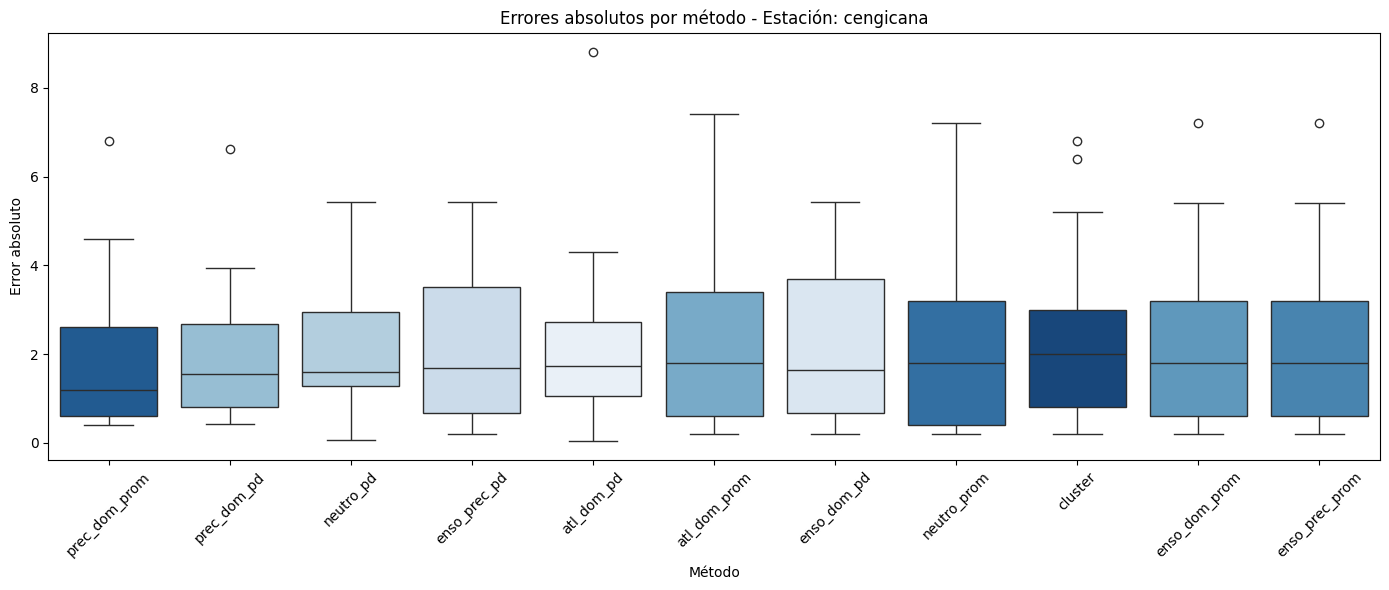


 Análisis para la estación: laborovalle
--------------------------------------------------


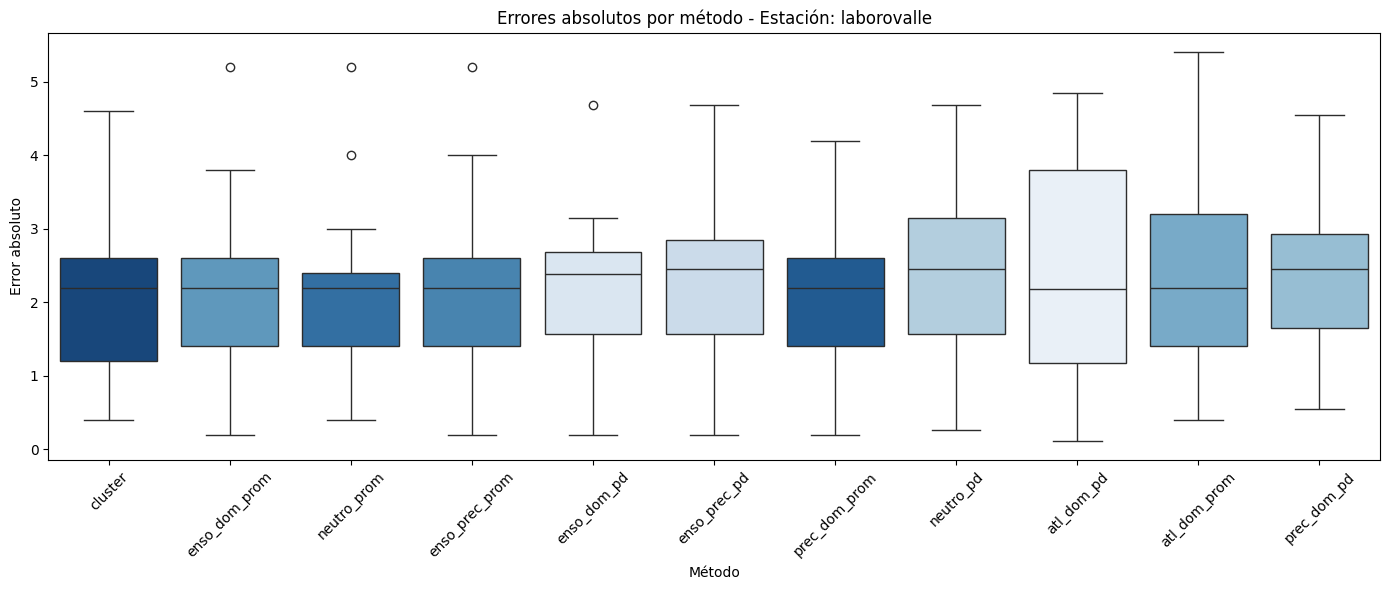


 Análisis para la estación: lafragua
--------------------------------------------------


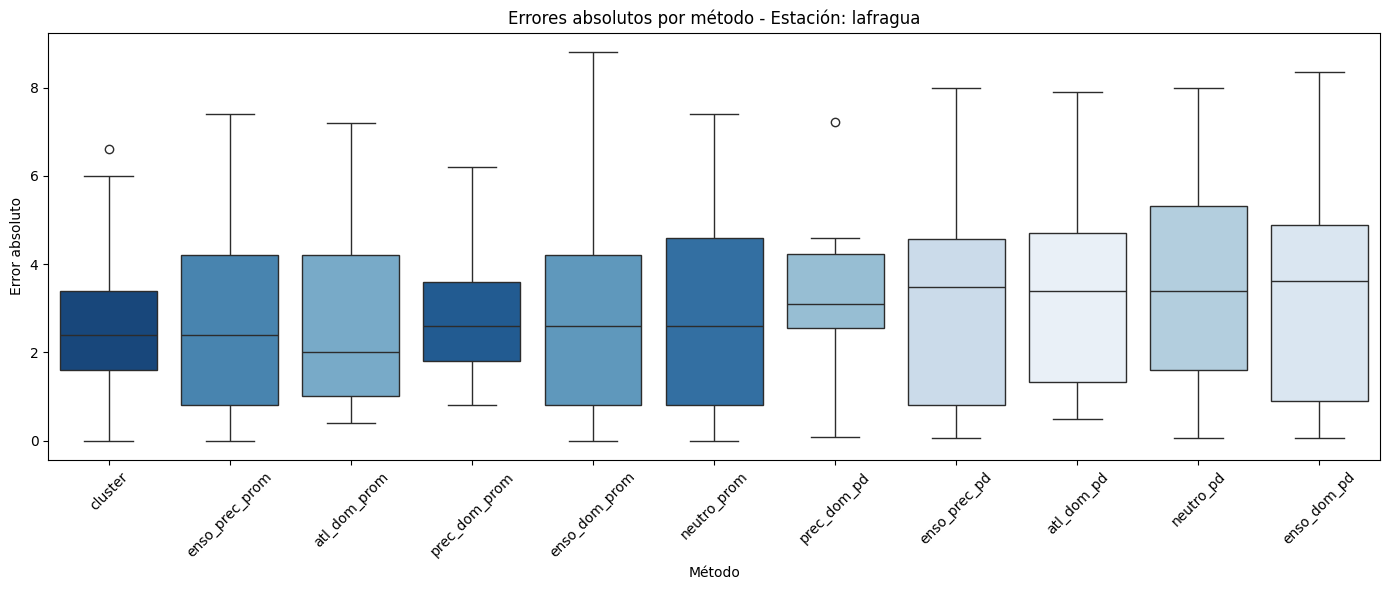


 Análisis para la estación: puertosanjose
--------------------------------------------------


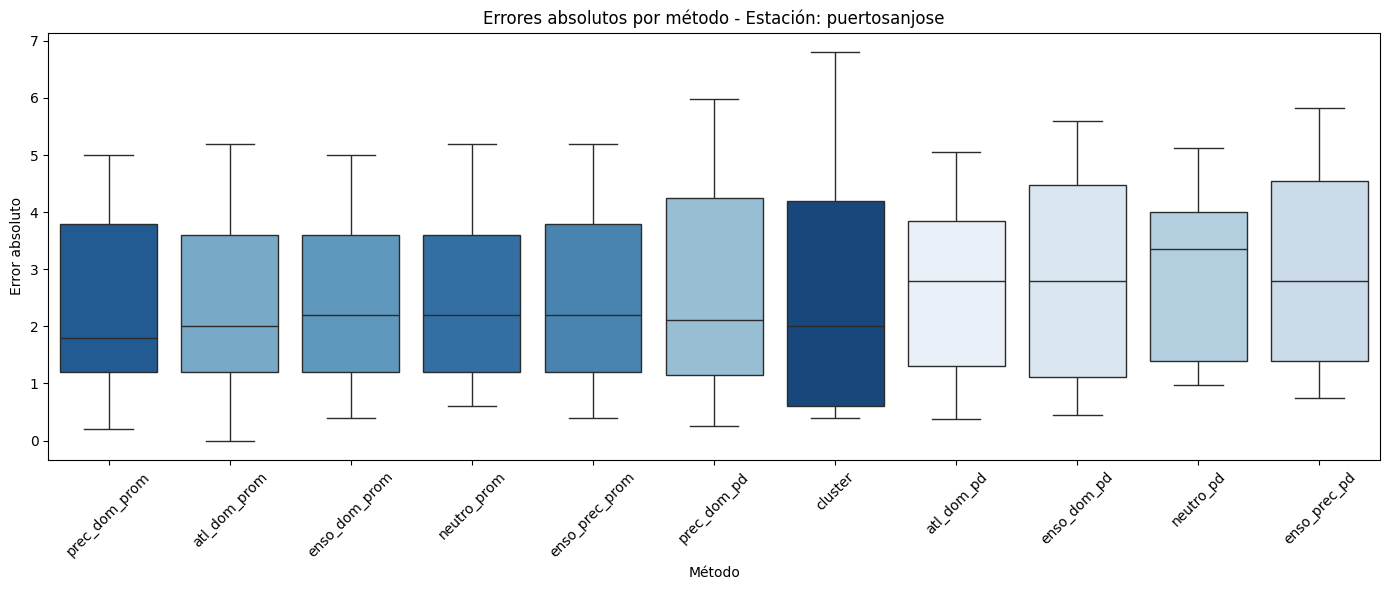

In [4]:

columnas_excluir = ['year', 'sem_iell_real', 'fase', 'station']
metodos = [col for col in retro.columns if col not in columnas_excluir]

# Iterar sobre cada estación
for estacion in retro['station'].unique():
    print(f"\n Análisis para la estación: {estacion}\n{'-'*50}")
    
    errores = retro[retro.station == estacion].copy()


    for metodo in metodos:
        errores[metodo] = abs(errores[metodo] - errores['sem_iell_real']).round(2)

 
    errores_long = errores.melt(
        id_vars=['year', 'sem_iell_real'],
        value_vars=metodos,
        var_name='metodo',
        value_name='error_absoluto'
    )

  
    orden_metodos = errores_long.groupby('metodo')['error_absoluto'].mean().sort_values().index.tolist()

   
    plt.figure(figsize=(14,6))
    sns.boxplot(
        data=errores_long, 
        x='metodo', 
        y='error_absoluto', 
        hue='metodo', 
        palette='Blues', 
        order=orden_metodos
    )
    # Quitar la leyenda innecesaria
    plt.legend([],[], frameon=False)
    plt.xticks(rotation=45)
    plt.title(f'Errores absolutos por método - Estación: {estacion}')
    plt.ylabel('Error absoluto')
    plt.xlabel('Método')
    plt.tight_layout()
    plt.show()



 Generando gráficos para la estación: cengicana
--------------------------------------------------


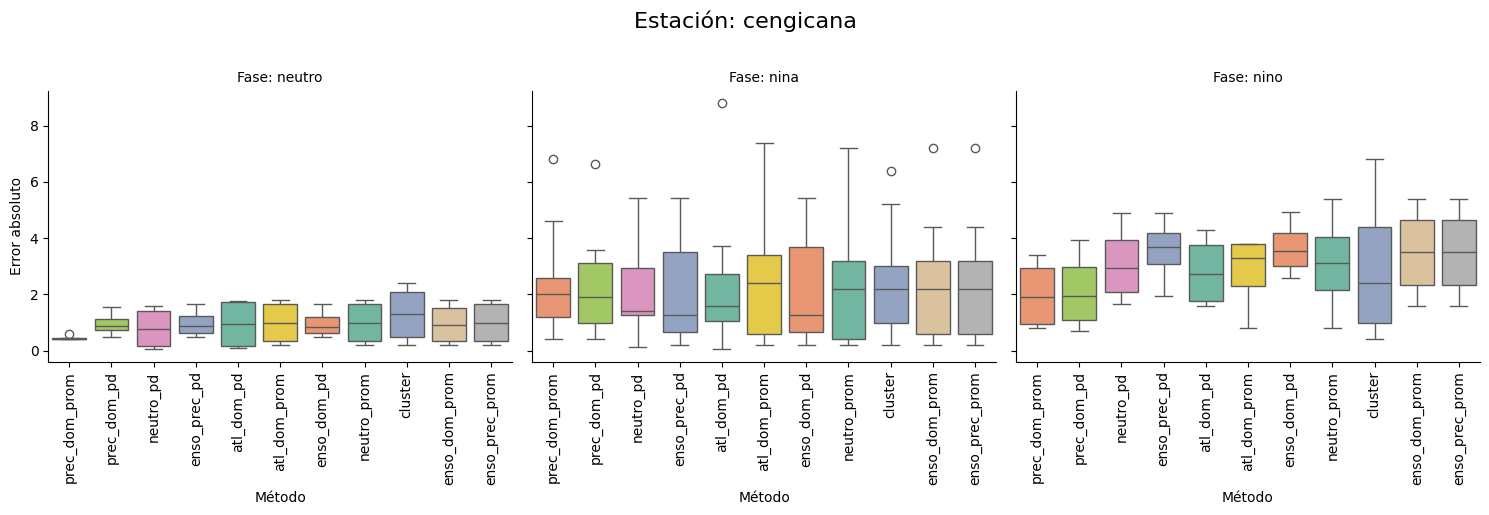


 Generando gráficos para la estación: laborovalle
--------------------------------------------------


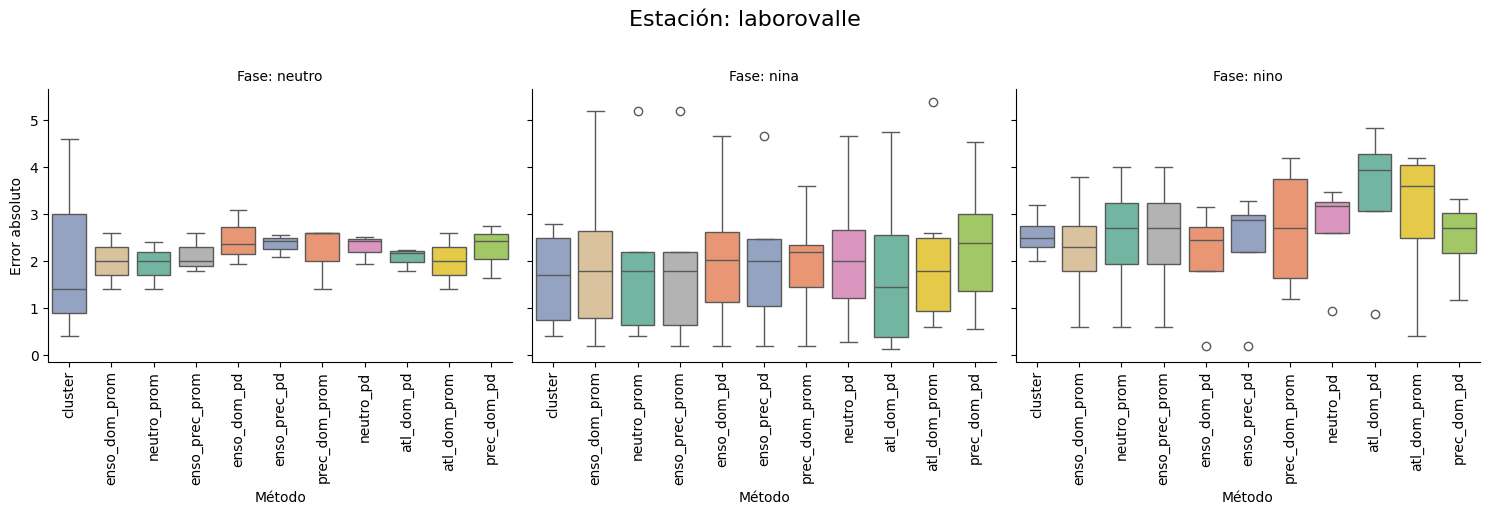


 Generando gráficos para la estación: lafragua
--------------------------------------------------


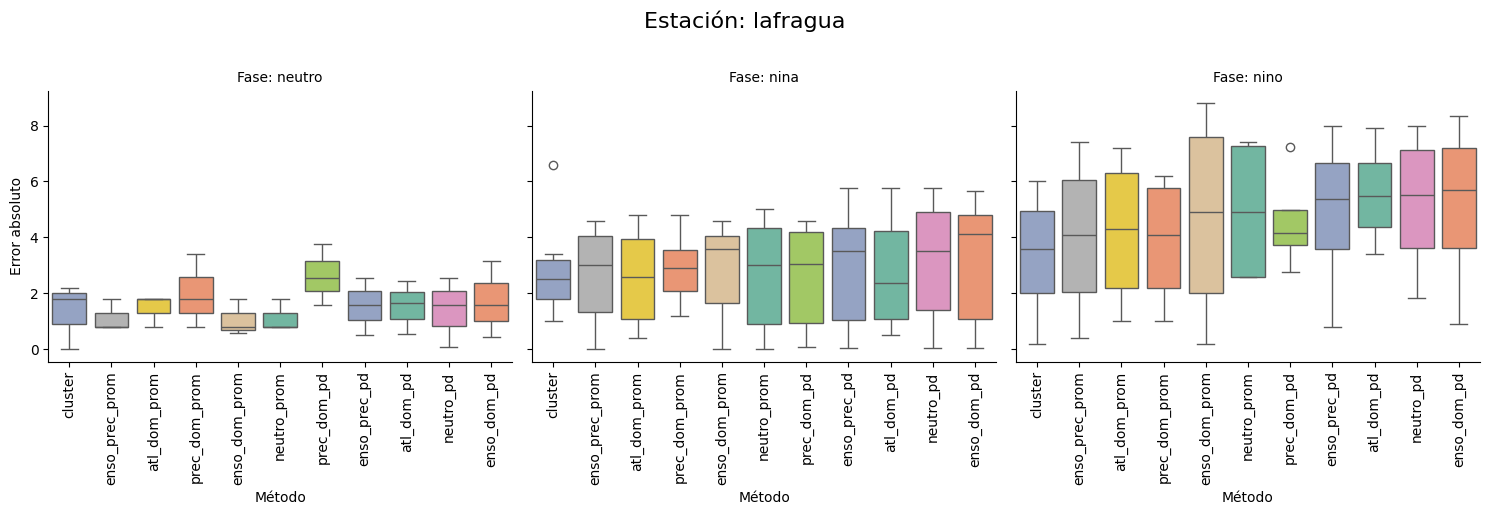


 Generando gráficos para la estación: puertosanjose
--------------------------------------------------


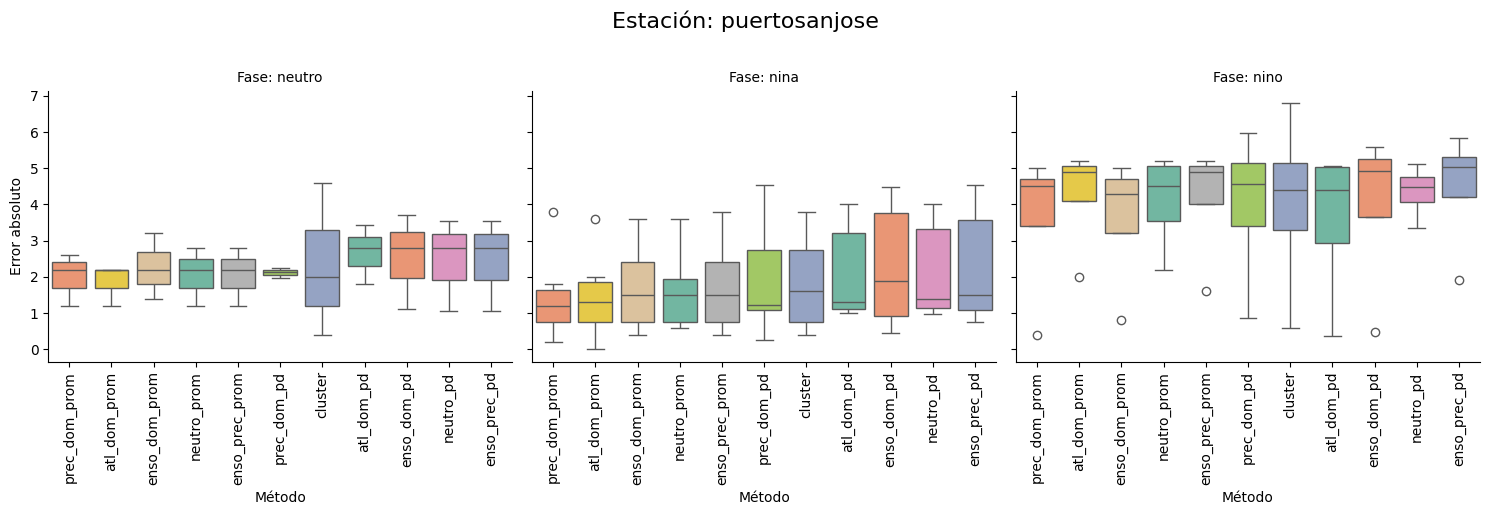

In [5]:

columnas_excluir = ['year', 'sem_iell_real', 'fase', 'station']
metodos = [col for col in retro.columns if col not in columnas_excluir]

# Iterar sobre cada estación disponible
for estacion in retro['station'].unique():
    print(f"\n Generando gráficos para la estación: {estacion}\n{'-'*50}")
    
    errores = retro[retro.station == estacion].copy()

    # Calcular errores absolutos
    for metodo in metodos:
        errores[metodo] = abs(errores[metodo] - errores['sem_iell_real'])

  
    errores_long = errores.melt(
        id_vars=['year', 'sem_iell_real', 'fase'],
        value_vars=metodos,
        var_name='metodo',
        value_name='error_absoluto'
    )

   
    orden_metodos = errores_long.groupby('metodo')['error_absoluto'].mean().sort_values().index.tolist()

    # Crear gráfico  por fase
    g = sns.FacetGrid(errores_long, col='fase', col_wrap=3, height=5, sharey=True)

    # Usamos hue, con el orden calculado
    g.map_dataframe(
        sns.boxplot, 
        x='metodo', 
        y='error_absoluto', 
        hue='metodo', 
        palette='Set2', 
        order=orden_metodos,
        legend=False
    )

    g.set_titles(col_template='Fase: {col_name}')

    for ax in g.axes.flatten():
        ax.tick_params(axis='x', rotation=90)
        ax.set_xlabel('Método')
        ax.set_ylabel('Error absoluto')

    plt.suptitle(f'Estación: {estacion}', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()


# Test Estadisticos

In [6]:

columnas_excluir = ['year', 'month', 'sem_iell_real', 'fase', 'station']
columnas_modelos = [col for col in retro.columns if col not in columnas_excluir and pd.api.types.is_numeric_dtype(retro[col])]

resultados_shapiro = []


for estacion in retro['station'].unique():
    df = retro[retro['station'] == estacion].copy()
    
    
    errores = df[columnas_modelos].subtract(df['sem_iell_real'], axis=0).abs()

    for col in errores.columns:
        datos = errores[col].dropna()
        if len(datos) >= 3:
            stat, p = shapiro(datos)
            resultados_shapiro.append({
                'estacion': estacion,
                'modelo': col.strip(),
                'estadistico_W': round(stat, 4),
                'p_valor': round(p, 4),
                'normalidad': 'Sí' if p > 0.05 else 'No'
            })
        else:
            resultados_shapiro.append({
                'estacion': estacion,
                'modelo': col.strip(),
                'estadistico_W': None,
                'p_valor': None,
                'normalidad': 'No evaluable (menos de 3 datos)'
            })

df_resultados_shapiro = pd.DataFrame(resultados_shapiro)


pd.set_option('display.max_rows', None)
df_resultados_shapiro[df_resultados_shapiro.estacion=='cengicana']


,estacion,modelo,estadistico_W,p_valor,normalidad
0,cengicana,atl_dom_pd,0.8091,0.0027,No
1,cengicana,enso_dom_pd,0.9051,0.0826,Sí
2,cengicana,enso_prec_pd,0.9040,0.0793,Sí
3,cengicana,neutro_pd,0.9149,0.1213,Sí
4,cengicana,prec_dom_pd,0.8413,0.0079,No
5,cengicana,atl_dom_prom,0.8864,0.0404,No
6,cengicana,enso_dom_prom,0.9065,0.0873,Sí
7,cengicana,enso_prec_prom,0.9080,0.0927,Sí
8,cengicana,neutro_prom,0.8997,0.0672,Sí
9,cengicana,prec_dom_prom,0.8069,0.0025,No


In [14]:


# Filtrar solo una estación con normalidad
df_estacion = retro[retro['station'] == 'lafragua'].copy()

# Derivar los errores absolutos
columnas_excluir = ['year', 'month', 'sem_iell_real', 'fase', 'station']
modelos = [col for col in retro.columns if col not in columnas_excluir and pd.api.types.is_numeric_dtype(retro[col])]

errores_abs = df_estacion[modelos].subtract(df_estacion['sem_iell_real'], axis=0).abs()
errores_abs['year'] = df_estacion['year']

# Llevar el dataset a formato long
errores_long = errores_abs.melt(id_vars='year', value_vars=modelos, var_name='modelo', value_name='error_abs')

# Aplicar la prueba de esfericidad de Mauchly
spher_result = pg.sphericity(data=errores_long, dv='error_abs', subject='year', within='modelo')

# Extraer los valores directamente del objeto SpherResults
w = spher_result.W
chi2 = spher_result.chi2
dof = spher_result.dof
pval = spher_result.pval

print(f"Estadístico W = {w:.4f}")
print(f"Chi² = {chi2:.4f}, GL = {dof}")
print(f"p-valor = {pval:.8f}")

if pval > 0.05:
    print(" Se cumple la esfericidad, puedes aplicar ANOVA clásico.")
else:
    print(" No se cumple la esfericidad, aplica Greenhouse-Geisser o Huynh-Feldt.")





Estadístico W = 0.0000
Chi² = 150.0130, GL = 54
p-valor = 0.00000000
 No se cumple la esfericidad, aplica Greenhouse-Geisser o Huynh-Feldt.


In [8]:

# Filtrar solo abril, eso era cuando tenia con marzo, ahora no
abril = retro.copy()

columnas_excluir = ['year',  'sem_iell_real', 'fase', 'station']
columnas_modelos = [col for col in retro.columns if col not in columnas_excluir and pd.api.types.is_numeric_dtype(retro[col])]

print(" TEST DE FRIEDMAN POR ESTACIÓN\n" + "="*40)


for estacion in abril['station'].unique():
    df = abril[abril['station'] == estacion].copy()

    # Calcular errores absolutos
    errores = df[columnas_modelos].subtract(df['sem_iell_real'], axis=0).abs()

    print(f"\nEstación: {estacion}")
    if errores.shape[0] >= 3:
        # Aplicar Friedman
        stat, p = friedmanchisquare(*[errores[col] for col in errores.columns])

        print(f"Estadístico χ² = {stat:.4f}, p = {p:.4f}")
        if p < 0.05:
            print("Hay diferencias significativas entre modelos.")
        else:
            print(" No hay diferencias significativas entre modelos.")
    else:
        print(" No hay suficientes observaciones (mínimo 3) para aplicar Friedman.")


 TEST DE FRIEDMAN POR ESTACIÓN

Estación: cengicana
Estadístico χ² = 10.0223, p = 0.4385
 No hay diferencias significativas entre modelos.

Estación: laborovalle
Estadístico χ² = 6.2001, p = 0.7982
 No hay diferencias significativas entre modelos.

Estación: lafragua
Estadístico χ² = 5.7401, p = 0.8366
 No hay diferencias significativas entre modelos.

Estación: puertosanjose
Estadístico χ² = 20.3369, p = 0.0262
Hay diferencias significativas entre modelos.


In [9]:

abril = retro.copy()

columnas_excluir = ['year', 'sem_iell_real', 'fase', 'station']
columnas_modelos = [col for col in retro.columns if col not in columnas_excluir and pd.api.types.is_numeric_dtype(retro[col])]

# Lista global para resultados
resultados_por_fase_y_estacion = []

# Iterar sobre cada estación
for estacion in abril['station'].unique():
    df_est = abril[abril['station'] == estacion].copy()

    # Iterar sobre cada fase dentro de la estación
    for fase, grupo in df_est.groupby('fase'):
        errores_abs = grupo[columnas_modelos].subtract(grupo['sem_iell_real'], axis=0).abs()
        n_obs = errores_abs.shape[0]

        if n_obs >= 3:
            stat, p = friedmanchisquare(*[errores_abs[col] for col in errores_abs.columns])
            conclusion = " Hay diferencias significativas" if p < 0.05 else " No hay diferencias significativas"
        else:
            stat, p = None, None
            conclusion = " Insuficientes observaciones"

        resultados_por_fase_y_estacion.append({
            "estacion": estacion,
            "fase": fase,
            "años_en_fase": n_obs,
            "estadístico_χ²": stat,
            "p_valor": p,
            "conclusión": conclusion
        })

# Crear DataFrame resumen
df_friedman_fase_estacion = pd.DataFrame(resultados_por_fase_y_estacion)

df_friedman_fase_estacion


,estacion,fase,años_en_fase,estadístico_χ²,p_valor,conclusión
0,cengicana,neutro,4,6.383764,0.782057,No hay diferencias significativas
1,cengicana,nina,9,1.814873,0.997572,No hay diferencias significativas
2,cengicana,nino,4,22.578763,0.012413,Hay diferencias significativas
3,laborovalle,neutro,3,10.570033,0.391982,No hay diferencias significativas
4,laborovalle,nina,6,7.235060,0.703083,No hay diferencias significativas
5,laborovalle,nino,4,13.313953,0.206644,No hay diferencias significativas
6,lafragua,neutro,3,7.277147,0.699047,No hay diferencias significativas
7,lafragua,nina,6,7.200622,0.706379,No hay diferencias significativas
8,lafragua,nino,4,13.895349,0.177819,No hay diferencias significativas
9,puertosanjose,neutro,3,5.915721,0.822294,No hay diferencias significativas


In [ ]:

# Filtrar solo abril
abril = retro.copy()


columnas_excluir = ['year',  'sem_iell_real', 'fase', 'station']
modelos = [col for col in retro.columns if col not in columnas_excluir and pd.api.types.is_numeric_dtype(retro[col])]


resultados_wilcoxon = []


for estacion in abril['station'].unique():
    df = abril[abril['station'] == estacion].copy()

 
    errores = df[modelos].subtract(df['sem_iell_real'], axis=0).abs()

    # Aplicar Wilcoxon a todos los pares de modelos
    for m1, m2 in combinations(modelos, 2):
        try:
            stat, p = wilcoxon(errores[m1], errores[m2])
            resultados_wilcoxon.append({
                'estacion': estacion,
                'modelo_1': m1.strip(),
                'modelo_2': m2.strip(),
                'estadístico_W': round(stat, 4),
                'p_valor': round(p, 4),
                'significativo (p<0.05)': p < 0.05
            })
        except ValueError as e:
            resultados_wilcoxon.append({
                'estacion': estacion,
                'modelo_1': m1.strip(),
                'modelo_2': m2.strip(),
                'estadístico_W': None,
                'p_valor': None,
                'significativo (p<0.05)': None,
                'error': str(e)
            })

# Convertir a DataFrame
df_resultados_wilcoxon = pd.DataFrame(resultados_wilcoxon)

df_resultados_wilcoxon.head()


,estacion,modelo_1,modelo_2,estadístico_W,p_valor,significativo (p<0.05)
0,cengicana,atl_dom_pd,enso_dom_pd,64.0,0.5791,False
1,cengicana,atl_dom_pd,enso_prec_pd,72.0,0.8536,False
2,cengicana,atl_dom_pd,neutro_pd,64.0,0.8361,False
3,cengicana,atl_dom_pd,prec_dom_pd,53.0,0.2842,False
4,cengicana,atl_dom_pd,atl_dom_prom,74.0,0.9265,False


In [13]:
df_resultados_wilcoxon[df_resultados_wilcoxon.estacion=='lafragua']['significativo (p<0.05)'].value_counts()

significativo (p<0.05)
False    52
True      3
Name: count, dtype: int64

In [ ]:
##Pruebas

In [ ]:
## analisis de varianzas

In [ ]:
import pandas as pd
from scipy.stats import f_oneway, shapiro, levene
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar solo mes de abril
retro_abril = retro[retro['station'] == 'laborovalle'].reset_index(drop=True)

# Calcular errores absolutos
predicciones = retro_abril.drop(columns=['year', 'station', 'sem_iell_real'])
errores = predicciones.subtract(retro_abril['sem_iell_real'], axis=0).abs()

# ANOVA.... hay diferencias significativas entre los modelos ... p debe ser menor a 0.05 para que asis sea
anova_result = f_oneway(*[errores[col] for col in errores.columns])


print(f"F = {anova_result.statistic:.4f}, p = {anova_result.pvalue:.4f}")



In [ ]:
# Test de normalidad (Shapiro-Wilk) si p<= 0.05 no siguen una dis norml
normalidad = {col: shapiro(errores[col]) for col in errores.columns}

for col, res in normalidad.items():
    print(f"{col:25s}   {res.statistic:.3f}, p = {res.pvalue:.4f}")


In [ ]:
errores = retro[retro.month==4].drop(columns=['year', 'month', 'real']).subtract(retro[retro.month==4]['real'], axis=0).abs().reset_index(drop=True)
errores

In [ ]:
# test de friedman (no parametrico)... compara los rrangos del error en el mismo año... si p< 0.05 al menos un modelo es diferente
from scipy.stats import friedmanchisquare

# correr la prueba
friedmanchisquare(*[errores[col] for col in errores.columns])


In [ ]:
from scipy.stats import mannwhitneyu # muestras normales para dos grupos
stat, p = mannwhitneyu(grupo1, grupo2)

from scipy.stats import kruskal # anova tipo (para fdif grupos)... no parametricas
stat, p = kruskal(grupo1, grupo2, grupo3)

from scipy.stats import wilcoxon
stat, p = wilcoxon(dif1, dif2)--------muestras pariadas


from scipy.stats import friedmanchisquare
stat, p = friedmanchisquare(medida1, medida2, medida3)---- anova no paraprametrica para no pariada

In [ ]:
import scikit_posthocs as sp
sp.posthoc_nemenyi_friedman(errores)


In [ ]:
ranking = errores.rank(axis=1)
ranking_promedio = ranking.mean().sort_values()
print(ranking_promedio)


In [ ]:
import pandas as pd
import numpy as np

# =========================
# FUNCIONES AUXILIARES
# =========================

def calcular_maape(y_true, y_pred):
    """
    Calcula el MAAPE (Mean Arctangent Absolute Percentage Error)
    entre dos listas o arrays numéricos.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.arctan(np.abs((y_true - y_pred) / (y_true + 1e-6))))

def construir_serie(df, año, mes, var):
    """
    Construye una serie de 6 meses consecutivos terminando en abril del año actual:
    Dic y Nov del año anterior, y Ene a Abr del año actual.
    """
    df = df[['year', 'month', var]]
    meses = [(año-1, 12), (año-1, 11), (año, 1), (año, 2), (año, 3), (año, 4)]
    serie = []
    for y, m in meses:
        valor = df[(df['year'] == y) & (df['month'] == m)]
        if valor.empty:
            return None
        serie.append(valor.iloc[0][var])
    return serie

# =========================
# CARGA DE DATOS
# =========================

ruta_prec = "D:\\OneDrive - CGIAR\\agrilac\\icc\\data\\laborovalle_prec.xlsx"
ruta_real = "D:\\OneDrive - CGIAR\\agrilac\\icc\\data\\start_prec_laborovalle.xlsx"
ruta_atl = "D:\\OneDrive - CGIAR\\agrilac\\icc\\data\\oni_atlantico.xlsx"
ruta_pac = "D:\\OneDrive - CGIAR\\agrilac\\icc\\data\\oni_pacifico.xlsx"

prec = pd.read_excel(ruta_prec)
real = pd.read_excel(ruta_real)
atl = pd.read_excel(ruta_atl)
pac = pd.read_excel(ruta_pac)

# Renombrar columnas para estandarizar nombres
atl.rename(columns={'oni': 'atl'}, inplace=True)
pac.rename(columns={'oni': 'pac'}, inplace=True)

# =========================
# CONFIGURACIÓN
# =========================

año_actual = 2018
mes_actual = 4
nombre_estacion = 'laborovalle'

escenarios = {
    'prec_dom': {'prec': 0.7, 'pac': 0.15, 'atl': 0.15},
    'enso_dom': {'prec': 0.3, 'pac': 0.5, 'atl': 0.2},
    'enso_prec': {'prec': 0.4, 'pac': 0.4, 'atl': 0.2},
    'neutro': {'prec': 0.33, 'pac': 0.33, 'atl': 0.33},
    'atl_dom': {'prec': 0.3, 'pac': 0.2, 'atl': 0.5},
}

# =========================
# CÁLCULO DE SERIES ACTUALES
# =========================

serie_actual_prec = construir_serie(prec, año_actual, mes_actual, 'prec')
serie_actual_atl = construir_serie(atl, año_actual, mes_actual, 'atl')
serie_actual_pac = construir_serie(pac, año_actual, mes_actual, 'pac')

if None in [serie_actual_prec, serie_actual_atl, serie_actual_pac]:
    print("No hay suficientes datos para calcular la serie actual.")
    exit()

# =========================
# COMPARACIÓN CON AÑOS ANTERIORES
# =========================

resultados = []

for año_pasado in range(año_actual-1, prec['year'].min()-1, -1):
    serie_ant_prec = construir_serie(prec, año_pasado, mes_actual, 'prec')
    serie_ant_atl = construir_serie(atl, año_pasado, mes_actual, 'atl')
    serie_ant_pac = construir_serie(pac, año_pasado, mes_actual, 'pac')

    if None in [serie_ant_prec, serie_ant_atl, serie_ant_pac]:
        continue

    maape_prec = calcular_maape(serie_actual_prec, serie_ant_prec)
    maape_atl = calcular_maape(serie_actual_atl, serie_ant_atl)
    maape_pac = calcular_maape(serie_actual_pac, serie_ant_pac)

    fila_real = real[real['year'] == año_pasado]
    semana_inicio = int(fila_real['sem_iell'].values[0]) if not fila_real.empty else np.nan

    resultados.append({
        'año': año_pasado,
        'maape_prec': maape_prec,
        'maape_atl': maape_atl,
        'maape_pac': maape_pac,
        'sem_iell': semana_inicio
    })

if len(resultados) < 8:
    print("No hay suficientes años anteriores con datos completos para comparar.")
    exit()

df_resultados = pd.DataFrame(resultados)

# =========================
# CÁLCULO DE ESCENARIOS
# =========================

df_final = pd.DataFrame()

for nombre_esc, pesos in escenarios.items():
    df_esc = df_resultados.copy()
    df_esc['maape_esc'] = (
        pesos['prec'] * df_esc['maape_prec'] +
        pesos['atl'] * df_esc['maape_atl'] +
        pesos['pac'] * df_esc['maape_pac']
    )
    df_esc = df_esc.sort_values('maape_esc').reset_index(drop=True)
    df_esc['escenario'] = nombre_esc
    df_esc['estacion'] = nombre_estacion

    # Calcular semana promedio y ponderada del top 5
    top5 = df_esc.head(5)
    semana_prom = top5['sem_iell'].mean()
    pesos_pond = np.array([0.5, 0.25, 0.1, 0.075, 0.075])
    semana_pond = np.sum(top5['sem_iell'].values * pesos_pond)

    df_final = pd.concat([df_final, pd.DataFrame({
        'escenario': [nombre_esc],
        'estacion': [nombre_estacion],
        'semana_promedio': [semana_prom],
        'semana_ponderada': [semana_pond]
    })], ignore_index=True)

# =========================
# RESULTADO FINAL
# =========================

print("\nResumen de resultados por escenario:")
print(df_final)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Rutas a los archivos individuales por estación
archivos = {
    'puerto san jose': r"D:\OneDrive - CGIAR\agrilac\icc\resultados\resultados_analogos_puerto_sanjose.xlsx",
    'laborovalle': r"D:\OneDrive - CGIAR\agrilac\icc\resultados\resultados_analogos_laborovalle.xlsx",
    'lafragua': r"D:\OneDrive - CGIAR\agrilac\icc\resultados\resultados_analogos_lafragua.xlsx",
    'cenicana': r"D:\OneDrive - CGIAR\agrilac\icc\resultados\resultados_analogos_cenicana.xlsx"
}

# Leer y unir todos los archivos
df_total = pd.DataFrame()

for estacion, ruta in archivos.items():
    if os.path.exists(ruta):
        df_temp = pd.read_excel(ruta)
        df_temp['estacion'] = estacion.lower()
        df_total = pd.concat([df_total, df_temp], ignore_index=True)
    else:
        print(f" Archivo no encontrado: {ruta}")

# Preparar datos para boxplot
df_prom = df_total[['estacion', 'escenario', 'error_abs_prom']].rename(columns={'error_abs_prom': 'error'})
df_prom['tipo'] = 'promedio'

df_pond = df_total[['estacion', 'escenario', 'error_abs_pond']].rename(columns={'error_abs_pond': 'error'})
df_pond['tipo'] = 'ponderado'

df_plot = pd.concat([df_prom, df_pond], ignore_index=True)

# Definir paleta de colores pastel personalizada
paleta = {'promedio': '#A8E6A2',  # verde pastel
          'ponderado': '#FFCC99'}  # naranja pastel

# Crear boxplots por estación
for estacion in archivos.keys():
    datos = df_plot[df_plot['estacion'] == estacion.lower()]
    if datos.empty:
        print(f" No hay datos para: {estacion}")
        continue

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=datos, x='escenario', y='error', hue='tipo', palette=paleta)
    plt.title(f'Errores absolutos - {estacion}')
    plt.xlabel('Escenario')
    plt.ylabel('Error absoluto')
    plt.xticks(rotation=45)

    # 🟢 Mover leyenda fuera del gráfico
    plt.legend(title='Tipo', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Rutas a los archivos individuales por estación
archivos = {
    'puerto san jose': r"D:\OneDrive - CGIAR\agrilac\icc\resultados\resultados_analogos_puerto_sanjose.xlsx",
    'laborovalle': r"D:\OneDrive - CGIAR\agrilac\icc\resultados\resultados_analogos_laborovalle.xlsx",
    'lafragua': r"D:\OneDrive - CGIAR\agrilac\icc\resultados\resultados_analogos_lafragua.xlsx",
    'cenicana': r"D:\OneDrive - CGIAR\agrilac\icc\resultados\resultados_analogos_cenicana.xlsx"
}

# Leer todos los datos y unirlos
df_total = pd.DataFrame()

for estacion, ruta in archivos.items():
    if os.path.exists(ruta):
        df_temp = pd.read_excel(ruta)
        df_temp['estacion'] = estacion.lower()
        df_total = pd.concat([df_total, df_temp], ignore_index=True)
    else:
        print(f" Archivo no encontrado: {ruta}")

# Función para generar mapa de calor para una estación y tipo de error
def plot_heatmap(df, tipo_error='promedio', estacion='cenicana'):
    columna_error = 'error_abs_prom' if tipo_error == 'promedio' else 'error_abs_pond'
    df_filtrado = df[df['estacion'] == estacion.lower()]
    
    if df_filtrado.empty:
        print(f" No hay datos para {estacion}")
        return

    tabla = df_filtrado.pivot(index='año_analizado', columns='escenario', values=columna_error)

    plt.figure(figsize=(10, 6))
    sns.heatmap(tabla, annot=True, fmt=".1f", cmap='coolwarm', cbar_kws={'label': f'Error absoluto ({tipo_error})'})
    plt.title(f'Mapa de calor de errores absolutos ({tipo_error}) - {estacion}')
    plt.xlabel('Escenario (modelo)')
    plt.ylabel('Año analizado')
    plt.tight_layout()
    plt.show()

# Crear mapas de calor para cada estación y tipo de error
for estacion in archivos.keys():
    plot_heatmap(df_total, tipo_error='promedio', estacion=estacion)
    plot_heatmap(df_total, tipo_error='ponderado', estacion=estacion)
